In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam


In [2]:
train_df = pd.read_csv("twitter/twitter_training.csv",header=None,names=['id','entity','sentiment','sen'])
test_df = pd.read_csv("twitter/twitter_validation.csv",header=None,names=['id','entity','sentiment','sen'])

In [3]:
print(train_df.info())
print("="*50)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   sen        73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   sen        1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None


In [45]:
dfs = [test_df, train_df]

df = pd.concat(dfs)
df = shuffle(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75682 entries, 14493 to 20783
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         75682 non-null  int64 
 1   entity     75682 non-null  object
 2   sentiment  75682 non-null  object
 3   sen        74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [46]:
df['sentiment'].value_counts()

Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: sentiment, dtype: int64

<AxesSubplot: >

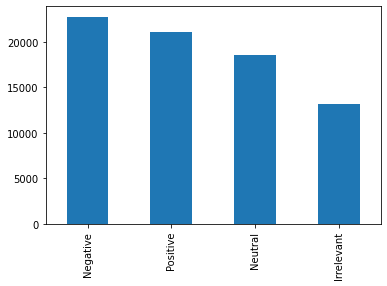

In [47]:
df.sentiment.value_counts().plot(kind='bar')

In [48]:
# df = df['sentiment'].drop('Irrelevant',axis=0)
# df = df[df.sentiment != 'Irrelevant']
df['sentiment'].value_counts()

Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: sentiment, dtype: int64

In [49]:
df.isna().sum()

id             0
entity         0
sentiment      0
sen          686
dtype: int64

In [50]:
df = df.dropna()

In [51]:
df.isna().sum()

id           0
entity       0
sentiment    0
sen          0
dtype: int64

- tokenization , padding

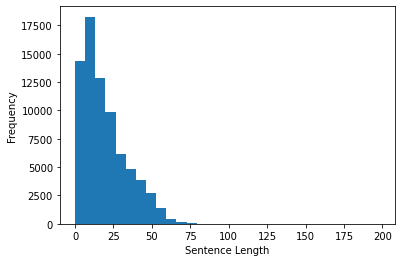

In [52]:
sentence_lengths = [len(sen.split()) for sen in df['sen']]


plt.hist(sentence_lengths, bins=30)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()    

In [53]:
num_records_100 = sum([1 for record in sentence_lengths if record > 75])
num_records_50 = sum([1 for record in sentence_lengths if record > 50])

print("num of records :", num_records_100 , " - with % : ", num_records_100 / len(sentence_lengths))
print("num of records :", num_records_50 , " - with % : ", num_records_50 / len(sentence_lengths))

num of records : 38  - with % :  0.0005066936903301509
num of records : 2780  - with % :  0.03706864366099525


In [54]:
unique_words = set()
for sentence in df['sen']:
    words = sentence.split()
    for word in words:
        unique_words.add(word)

num_unique_words = len(unique_words)
print(num_unique_words)

83514


In [55]:
max_length = 50
vocab_size = num_unique_words

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['sentiment'])
word_index = tokenizer.word_index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['sentiment'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')


In [56]:
labels_dict = {k: v for v, k in enumerate(df['sentiment'].unique())}
labels_dict

{'Positive': 0, 'Neutral': 1, 'Irrelevant': 2, 'Negative': 3}

In [57]:
num_labels = len(labels_dict)

In [58]:
labels_lst = df['sentiment'].replace(labels_dict)
labels_lst.value_counts()

labels = to_categorical(labels_lst,num_labels)
labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [59]:
# double check of argmax
if np.argmax(labels, axis=1).all() == labels_lst.all():
    print('yes')

yes


In [60]:
x_train, x_valid, y_train, y_valid = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42,shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.3, random_state=42,shuffle=True)


In [61]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(x_train[0].shape)

(59996, 50)
(10500, 50)
(4500, 50)
(50,)


In [62]:
import gensim.downloader as api

model_glove = api.load("glove-wiki-gigaword-50")


In [63]:
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in model_glove:
        embedding_matrix[i] = model_glove[word]


In [66]:
# Define the deep learning model
embedding_dim = 10
model = tf.keras.Sequential([
    # tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], 
    #                           input_length=max_length, trainable=False),
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 ,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

# Compile the model
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# Compile the model
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 10)            835140    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 128)          38400     
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 50, 128)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

In [67]:
# Train the model
history1 = model.fit(x_train, y_train, epochs=2, validation_data=(x_valid, y_valid))

Epoch 1/2
1875/1875 [==============================] - 126s 62ms/step - loss: 0.1448 - accuracy: 0.9423 - val_loss: 1.4980e-05 - val_accuracy: 1.0000
Epoch 2/2
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0684 - accuracy: 0.9799 - val_loss: 2.4963e-06 - val_accuracy: 1.0000


In [68]:
# # # Define the deep learning model
# model2 = tf.keras.Sequential([
#     # tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], 
#     #                           input_length=max_length,trainable = False),
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Conv1D(128, 5, activation='relu'),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(num_labels, activation='softmax')
# ])

# # # Compile the model
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
# model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model2.summary()


In [69]:
# # # Train the model
# history2 = model2.fit(x_train, y_train, epochs=2, validation_data=(x_valid, y_valid))

In [27]:
model.save('seintemntal.h5')

In [73]:
reverse_label_dict = {v: k for k, v in labels_dict.items()}

In [74]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# embedding_weights = embedding_layer.get_weights()[0]

def get_original_sen(x_test,reverse_word_index):
    # embedded_sentence = x_test
    # word_indices = np.argmax(embedded_sentence, axis=-1)
    words = [reverse_word_index.get(i, '<UNK>') for i in x_test]
    original_sentence = ' '.join(words)
    return original_sentence


In [75]:
def get_tags(reverse_label_dict,y_true,y_predict):
    y_pred_label = reverse_label_dict[y_predict]
    y_true_label = reverse_label_dict[np.argmax(y_true)]
    return y_true_label , y_pred_label

In [76]:
def predict(x,model):
    p = model.predict(np.array([x]))
    p = np.argmax(p, axis=-1)
    y_predict = p[0]
    return y_predict  

In [77]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test , y_test)
print('Test accuracy:', accuracy)

141/141 [==============================] - 2s 11ms/step - loss: 2.5525e-06 - accuracy: 1.0000
Test accuracy: 1.0


In [78]:
y_predict = predict(x_test[0],model)
y_predict



1/1 [==============================] - 2s 2s/step


1

In [38]:

# def prepare_test(test_df,tokenizer,pad_sequences,max_length,labels_dict):
#     sequences = tokenizer.texts_to_sequences(test_df['sen'])
#     padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')
#     labels_lst = test_df['sentiment'].replace(labels_dict)
#     labels = to_categorical(labels_lst,4)
#     return padded_sequences , labels

# padded_sequences_test , labels_test = prepare_test(test_df,tokenizer,pad_sequences,max_length,labels_dict)